In [42]:
import numpy as np
from numpy.lib.stride_tricks import as_strided as ast
import cv2
import matplotlib.pyplot as plt

In [43]:
def check_pot_overlap(xposit, yposit, pot_h, pot_w, back_h, back_w, pot):
    """Checks position of pot with background dimensions.

    Args:
        xposit (_type_): _description_
        yposit (_type_): _description_
        pot_h (_type_): _description_
        pot_w (_type_): _description_
        back_h (_type_): _description_
        back_w (_type_): _description_
        pot (_type_): _description_

    Returns:
        _type_: _description_
    """

    if xposit + pot_w > back_w:
        back_w = back_w - xposit
        pot = pot[:, :back_w]

    if yposit + pot_h > back_h:
        back_h = back_h - yposit
        pot = pot[:back_h,:]
    
    return pot, back_h, back_w



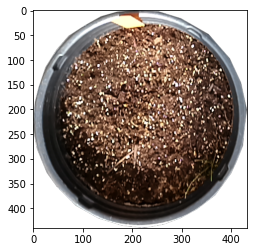

In [44]:
backpath = "../data/synth_data_test/backgrounds/wk4_row3_stop9_20210414_112459_rgb.png"
potp = "../data/synth_data_test/pots/wk2_row10_20210402_104219_rgb.png"
back = cv2.cvtColor(cv2.imread(backpath,cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGBA)
pot = cv2.cvtColor(cv2.imread(potp,cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGBA)
new_mask = np.zeros_like(back)


plt.imshow(pot)

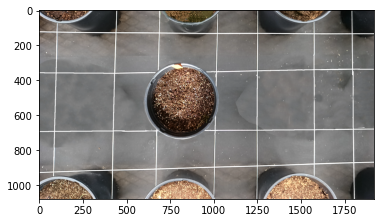

In [45]:
back_h, back_w, _ = back.shape
pot_h, pot_w, _ = pot.shape

xpos, ypos = 100, 220

pot_mask = pot[..., 3:] / 255
alpha_l = 1.0 - pot_mask


back[300:740,600:1033] = alpha_l * back[300:740,600:1033] + pot_mask* pot 

new_mask[300:740,600:1033] = (250) * pot_mask + new_mask[300:740,600:1033] * (1.0 - pot_mask)

plt.imshow(back)

440 433
220 217


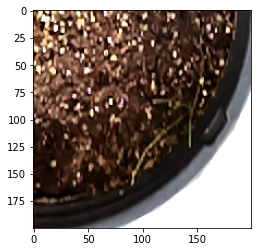

In [62]:
pot_h, pot_w, _ = pot.shape

centerh = pot_h - int(pot_h/2)
centerw = pot_w - int(pot_w/2)


xpos, ypos = 200, 200
croppot = pot[centerh:centerh+ypos, centerw:centerw+xpos]

plt.imshow(croppot)

In [67]:
msgr = np.meshgrid(pot[:,:,0])
len(msgr)

1

In [71]:
msgr[0].shape

(190520,)

In [73]:
from skimage.util import crop, view_as_blocks, view_as_windows, regular_grid

(1080, 1920, 4)


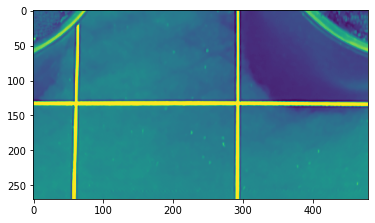

In [119]:
back = cv2.cvtColor(cv2.imread(backpath,cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGBA)
print(back.shape)
blocks = view_as_blocks(back, block_shape=(270, 480,1))
plt.imshow(blocks[0,2,1])

In [116]:
blocks

array([[[[[[ 44],
           [ 44],
           [ 42],
           ...,
           [151],
           [147],
           [149]],

          [[ 45],
           [ 43],
           [ 42],
           ...,
           [151],
           [147],
           [149]],

          [[ 46],
           [ 45],
           [ 42],
           ...,
           [151],
           [147],
           [149]],

          ...,

          [[255],
           [255],
           [255],
           ...,
           [255],
           [255],
           [255]],

          [[255],
           [255],
           [255],
           ...,
           [255],
           [255],
           [255]],

          [[255],
           [255],
           [255],
           ...,
           [255],
           [255],
           [255]]],


         [[[ 41],
           [ 41],
           [ 39],
           ...,
           [144],
           [141],
           [142]],

          [[ 43],
           [ 40],
           [ 39],
           ...,
           [144],
           [